# Modeling the Covid-19 Death rate relative to population size
In this step we are finding the right or best model to correlate death rates with the number of cases and the demography of a country. This will help us understand whether we can tell how harmful COVID 19 is for a given country based on its demography. Our model could be tested with more recent data of countries that did not have had confirmed cases of COVID-19 back in May.

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score,mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import time
%matplotlib inline
os.getcwd()

'/Users/lisahw/Documents/Courses and Conferences/DataScience/MyProject/Capstone_02/Springboard/notebooks'

### Read in Train and Test data sets

In [3]:
data_file = 'sqlite:///../data/final/COVID_Deaths_train_test.db'
X_train = pd.read_sql('SELECT * FROM XTRAIN',data_file,index_col='index')
X_test = pd.read_sql('SELECT * FROM XTEST',data_file,index_col='index')
y_train = np.ravel(pd.read_sql('SELECT * FROM yTRAIN',data_file,index_col='index'))
y_test = np.ravel(pd.read_sql('SELECT * FROM yTEST',data_file,index_col='index'))
X_train.drop('covid_fatal',axis=1,inplace=True)
X_test.drop('covid_fatal',axis=1,inplace=True)
X_train.head()

,Confirmed,Cardio Death Rate,Diabetes Percentage,Obesity,Undernourished,PopMale,Total Population,Cluster_1,Cluster_2
index,,,,,,,,,
145,-0.612502,-0.188623,-0.897430,-1.282407,2.990430,-1.073046,-0.191597,0,0
42,0.795560,-0.977732,-0.467855,0.081550,-0.228392,-0.211033,-0.194520,0,1
16,-0.552803,0.344180,0.287237,-1.612741,0.335731,-0.448477,0.679257,0,0
10,-0.514918,0.179408,-0.153011,0.859433,-0.560230,-0.321158,-0.040489,1,0
115,-0.494024,-0.036122,1.151723,0.561067,-0.410903,0.294547,-0.298068,1,0


Data has been standardized and clusters identified. There are 3 clusters, but one has been dropped to avoid covariance.

## Linear Regression Model

In [40]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)
print('Explained Variance: ',explained_variance_score(y_test,y_pred))
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',linreg.score(X_test,y_test))

Explained Variance:  0.5793536108113879
Mean square error:  1.1504095158604497
Mean absolute error:  0.485039155113458
R2 score/Coeff. of determination:  0.5505271951632207


The linear model does not perform very well on our data set. Potentially the underlying data is better described by a polynomial function with a degree higher than 1.

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import time
polyfeat = PolynomialFeatures(degree=2,include_bias=False)
linreg = LinearRegression()
pipeline = Pipeline([("polynomial_features", polyfeat),("linear_regression", linreg)])
t_start = time.time()
pipeline.fit(X_train,y_train)
print('Time to fit:',t_start-time.time())
t_start = time.time()
y_pred = pipeline.predict(X_test)
print('Time to predict:',t_start-time.time())
print('Explained Variance: ',explained_variance_score(y_test,y_pred))
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',pipeline.score(X_test,y_test))

Time to fit: -0.014178991317749023
Time to predict: -0.0031211376190185547
Explained Variance:  0.7884672004546821
Mean square error:  0.603095933995758
Mean absolute error:  0.39367753735795774
R2 score/Coeff. of determination:  0.7643663258157428


In [72]:
product = polyfeat.powers_ *("-"+X_train.columns.values)
end_product = [] # np.zeros(product.shape[0],dtype=str)
for i in range(product.shape[0]):
    end_product.append("".join(product[i,:])[1:])

The fit to the linear model is highly improved thanks to adding the polynomial features.

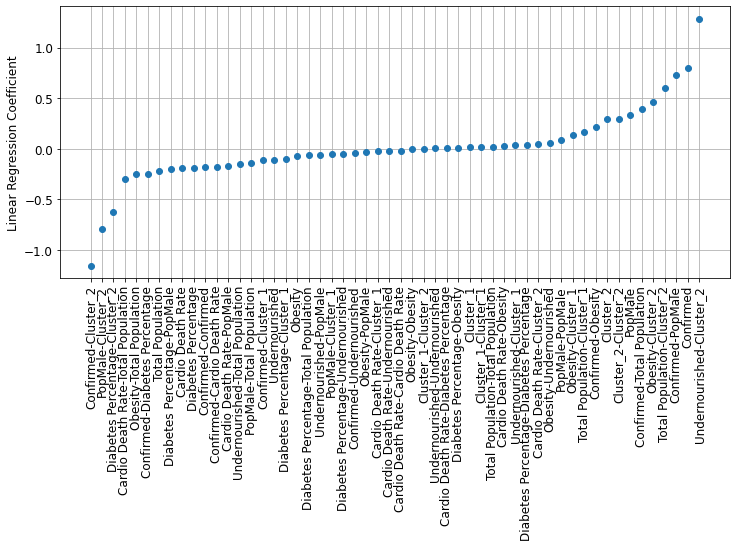

In [87]:
coefs = pipeline.named_steps['linear_regression'].coef_
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)
ind = argsort(coefs)
plt.figure(figsize=(12,5))
plt.plot(range(len(ind)),coefs[ind],'.',ms=12)
plt.xticks(range(len(ind)),labels=np.array(end_product)[ind],rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Linear Regression Coefficient',fontsize=12)
plt.grid()
plt.show()

In [124]:
for i in [0,1,2,3,-4,-3,-2,-1]:
    print(end_product[ind[i]],": ",coefs[ind[i]])

Cardio Death Rate :  -0.19298475278644042
Obesity :  -0.07042411013000036
Undernourished :  -0.1127879946176902
Total Population :  -0.2224202361672688
Cluster_2 :  0.29591665013181945
PopMale :  0.3336830204634398
Diabetes Percentage :  -0.18768477335683556
Confirmed :  0.797203017110173


## Decision Tree Regressor

Decision trees are usually used for classification problems, but are of value for a regression problem too. 

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)

print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Mean square error:  1.0038786953973788
R2 score/Coeff. of determination:  0.6077777811159193


In [7]:
param_grid = {"ccp_alpha": [0.0,0.5],
 "max_depth": [2,3, None],
 "max_features": [3, 6, 9],
 "min_samples_split": [2, 5],
 "min_samples_leaf": [1, 3]}
reg3 = DecisionTreeRegressor(random_state=42)
grid = GridSearchCV(estimator=reg3, param_grid=param_grid, n_jobs=-1,cv=2)
grid.fit(X_train, y_train)
print('Best score: ',grid.best_score_)
print('Best set of parameters: ' ,grid.best_params_)
y_pred = grid.predict(X_test)
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Best score:  0.5176525447980902
Best set of parameters:  {'ccp_alpha': 0.0, 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean square error:  1.0010994002666562
R2 score/Coeff. of determination:  0.608863670584541


The crossvalidation has slightly improved the model performance. The polynomial model still outperforms the Decision Tree Regressor.

In [21]:
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42, max_features=6,min_samples_leaf=3)
t_start = time.time()
tree_reg.fit(X_train, y_train)
print('Time to fit:',t_start-time.time())
t_start = time.time()
y_pred = tree_reg.predict(X_test)
print('Time to predict:',t_start-time.time())
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Time to fit: -0.0346219539642334
Time to predict: -0.009482145309448242
Mean square error:  1.0010994002666562
R2 score/Coeff. of determination:  0.608863670584541


In [24]:
tree_reg.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')>

In [123]:
ind = argsort(tree_reg.feature_importances_)
print('Feature Importance:')
for i in ind:
    print('{} : {:.1f}%'.format(X_train.columns[i],100*tree_reg.feature_importances_[i]))

Feature Importance:
Cardio Death Rate : 0.0%
Obesity : 0.0%
Undernourished : 0.0%
Total Population : 0.0%
Cluster_1 : 0.0%
Cluster_2 : 0.0%
PopMale : 1.4%
Diabetes Percentage : 22.3%
Confirmed : 76.3%


In [ ]:
# Now we want to visualize the tree
from IPython.display import SVG
from graphviz import Source
from sklearn import tree
import pydotplus

# We can do so with export_graphviz
graph = Source( tree.export_graphviz(tree_reg, out_file=None, feature_names=X_train.columns))
# SVG(graph.pipe(format='svg'))
graph.format = 'png'
graph.render('entr_model',view=True)

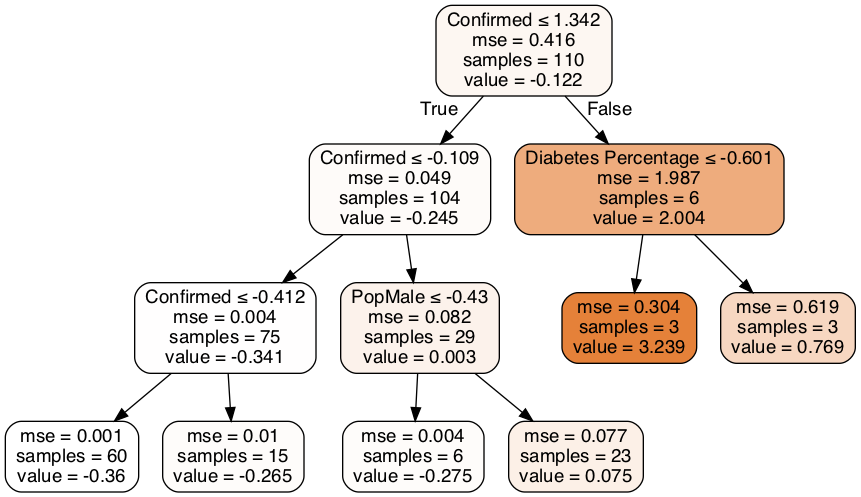

In [29]:
from sklearn.externals.six import StringIO  
from IPython.display import Image 
# # Alternatively for class_names use entr_model.classes_
# entr_model.classes_
# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(tree_reg, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"]) 

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

## Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=0, n_estimators=250)
# regressor = RandomForestRegressor(bootstrap= False,max_depth= 3, max_features= 6, min_samples_leaf= 3, min_samples_split=2,n_estimators= 250)
t_start = time.time()
regressor.fit(X_train.values, y_train)
print('Time to fit:',t_start-time.time())
t_start = time.time()
y_pred = regressor.predict(X_test.values)
print('Time to predict:',t_start-time.time())
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Time to fit: -0.5202898979187012
Time to predict: -0.026401996612548828
Mean square error:  0.7233439032509514
R2 score/Coeff. of determination:  0.7173846281924983


In [13]:
param_grid = {"n_estimators": [150,250],
 "max_depth": [3, None],
 "max_features": [3, 6, 9],
 "min_samples_split": [2, 5],
 "min_samples_leaf": [1, 3],\
 "bootstrap": [True, False]}
reg2 = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=reg2, param_grid=param_grid, n_jobs=-1,cv=2)
grid.fit(X_train.values, y_train)
print('Best score: ',grid.best_score_)
print('Best set of parameters: ' ,grid.best_params_)
y_pred = grid.predict(X_test.values)
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Best score:  0.5972685295650273
Best set of parameters:  {'bootstrap': False, 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Mean square error:  0.8554412044953067
R2 score/Coeff. of determination:  0.6657733161483169


Instead of just one decision tree, a Random Forest regressor is now used to model the data set. R2 score shows that the Random Forest regressor outperforms the single Decision Tree, but it does not compete with the polynomial Model.

A benefit of the Random Forest is that it provides the relative relevance of each feature. 

In [15]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)


In [120]:
regressor = RandomForestRegressor(random_state=0, n_estimators=250)

regressor.fit(X_train.values, y_train)
ind = argsort(regressor.feature_importances_)
labels = []
sizes = []
print('Feature Importance:')
for i in ind:
    if 100*regressor.feature_importances_[i] < 3:
        if 'other' not in labels:
            labels.append('other')
            sizes.append(100*regressor.feature_importances_[i])
        else:
            sizes[labels=='other']+=100*regressor.feature_importances_[i]
    else:
        labels.append(X_train.columns[i])
        sizes.append(100*regressor.feature_importances_[i])
    print('{} : {:.1f}%'.format(X_train.columns[i],100*regressor.feature_importances_[i]))

Feature Importance:
Cluster_1 : 0.1%
Cluster_2 : 0.1%
Undernourished : 0.4%
Cardio Death Rate : 2.4%
Obesity : 3.1%
Total Population : 3.2%
PopMale : 7.1%
Diabetes Percentage : 9.1%
Confirmed : 74.5%


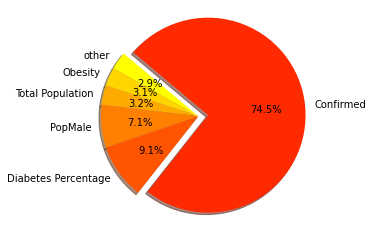

In [121]:
# Data to plot
explode = np.zeros(len(labels)) #(0.1, 0, 0, 0)  # explode 1st slice
explode[-1] = 0.1

# Plot
theme = plt.get_cmap('autumn_r')
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
ax1.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=True, startangle=140)



ax1.axis('equal')
fig1.savefig('../reports/figures/Pie_RandomForest.png')


We see that the most important feature is the number of comfirmed cases. This was to be expected, since deaths are correlated to incidents. Interestingly, the Diabetes Percentage appears to be more relevant than the fraction of male population above 70. But with our mission to predict which other countries might be affected but do not have confirmed cases yet, this result does not help us.

In [25]:
regressor.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)>

## Gradient Boosting Regressor

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
# Fit the model on the trainng data.
gbr.fit(X_train, y_train)
# Print the accuracy from the testing data.
y_pred = gbr.predict(X_test)
print('Explained Variance: ',explained_variance_score(y_test,y_pred))
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Explained Variance:  0.6220304803184152
Mean square error:  1.001501102475978
Mean absolute error:  0.41932417878565015
R2 score/Coeff. of determination:  0.6087067228052991


In [18]:
param_grid = {"n_estimators": [100,150,250],
              "subsample": [0.5,0.75,1],
 "max_depth": [3, None],
 "max_features": [3, 6, 9],
 "min_samples_split": [2, 5],
 "min_samples_leaf": [1, 3]}
gbr = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=-1,cv=2)
grid.fit(X_train, y_train)
print('Best score: ',grid.best_score_)
print('Best set of parameters: ' ,grid.best_params_)
y_pred = grid.predict(X_test)
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Best score:  0.6475079527457719
Best set of parameters:  {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250, 'subsample': 1}
Mean square error:  0.7778044608213309
R2 score/Coeff. of determination:  0.6961065187656785


In [117]:
gbr = GradientBoostingRegressor(random_state=42,max_depth=3,max_features=3,n_estimators=150)
t_start = time.time()
gbr.fit(X_train,y_train)
print('Time to fit:',t_start-time.time())
t_start = time.time()
ind = argsort(gbr.feature_importances_)
print('Time to predict:',t_start-time.time())
print('Feature Importance:')
labels = []
sizes = []
for i in ind:
    if 100*gbr.feature_importances_[i] < 3:
        if 'other' not in labels:
            labels.append('other')
            sizes.append(100*gbr.feature_importances_[i])
        else:
            sizes[labels=='other']+=100*gbr.feature_importances_[i]
    else:
        labels.append(X_train.columns[i])
        sizes.append(100*gbr.feature_importances_[i])
    print('{} : {:.1f}%'.format(X_train.columns[i],100*gbr.feature_importances_[i]))

Time to fit: -0.08789491653442383
Time to predict: -0.0017271041870117188
Feature Importance:
Cluster_2 : 1.1%
Undernourished : 1.8%
Cluster_1 : 2.0%
Obesity : 5.4%
Cardio Death Rate : 6.2%
Total Population : 8.5%
Diabetes Percentage : 13.4%
PopMale : 20.5%
Confirmed : 41.2%


The Random Forest model outperforms the Gradient Boosting and all other models. Interestingly, the Gradient Boosting gives less importance to the number of confirmed cases and increases the importance of the percentage of males older than 75. The diabetes percentage is on rank three this time.

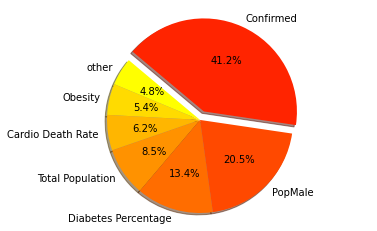

In [119]:
explode = np.zeros(len(labels)) #(0.1, 0, 0, 0)  # explode 1st slice
explode[-1] = 0.1

# Plot
theme = plt.get_cmap('autumn_r')
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
ax1.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=True, startangle=140)



ax1.axis('equal')
fig1.savefig('../reports/figures/Pie_GradientBoosting.png')


In [26]:
gbr.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)>